# lorapy symbol extraction

In [1]:
%load_ext autoreload
%autoreload 2

import pathlib

import os, sys
from loguru import logger
logger.remove(None)
logger.add(sys.stdout, colorize=True)

import numpy as np
from six.moves import cPickle
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt 
plt.style.use('dark_background')
%matplotlib inline

In [2]:
import lorapy

## setup 

In [3]:
_BASE_DATA_DIR = pathlib.Path('/Users/trevor/Work/1-projects/lora-processing/data')

BENCHTOP_DATA_DIR = _BASE_DATA_DIR.joinpath('lora-benchtop-recording')
OTA_DATA_DIR = _BASE_DATA_DIR.joinpath('LoRa_Recording_OTA')
OUTDOOR_DATA_DIR = _BASE_DATA_DIR.joinpath('LoRa_Recording_Outdoor')
DOTP_DATA_DIR = _BASE_DATA_DIR.joinpath('symbol-ref')
SYMBOL_DIR = _BASE_DATA_DIR.joinpath('lora-symbols-20k')
PREAM_WIN_DIR = _BASE_DATA_DIR.joinpath('lora-preamble-windows-20k')

# load

## preamble windows

In [4]:
loader = lorapy.load_dotp(PREAM_WIN_DIR, autoload=True)
loader.file_list

2020-04-09 15:57:53.976 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: /Users/trevor/Work/1-projects/lora-processing/data/lora-preamble-windows-20k
2020-04-09 15:57:53.982 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 75 data file(s)


[DotPFile(id=0 | name='lora_BW2_SF11_915MHz_20ksps_Att60_v0.p'),
 DotPFile(id=1 | name='lora_BW8_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=2 | name='lora_BW8_SF12_915MHz_20ksps_Att20_v0.p'),
 DotPFile(id=3 | name='lora_BW1_SF11_915MHz_20ksps_Att80_v0.p'),
 DotPFile(id=4 | name='lora_BW8_SF10_915MHz_20ksps_Att80_v0.p'),
 DotPFile(id=5 | name='lora_BW7_SF12_915MHz_20ksps_Att20_v0.p'),
 DotPFile(id=6 | name='lora_BW2_SF11_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=7 | name='lora_BW2_SF12_915MHz_20ksps_Att120_v0.p'),
 DotPFile(id=8 | name='lora_BW8_SF12_915MHz_20ksps_Att100_v0.p'),
 DotPFile(id=9 | name='lora_BW8_SF12_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=10 | name='lora_BW8_SF12_915MHz_20ksps_Att60_v0.p'),
 DotPFile(id=11 | name='lora_BW2_SF12_915MHz_20ksps_Att100_v0.p'),
 DotPFile(id=12 | name='lora_BW8_SF12_915MHz_20ksps_Att120_v0.p'),
 DotPFile(id=13 | name='lora_BW2_SF11_915MHz_20ksps_Att20_v0.p'),
 DotPFile(id=14 | name='lora_BW1_SF11_915MHz_20ksps_Att120_v0.p'),
 DotPFile(id=15 

## dotp files

In [5]:
ploader = lorapy.load_dotp(DOTP_DATA_DIR)
ploader.file_list

2020-04-09 15:57:54.025 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: /Users/trevor/Work/1-projects/lora-processing/data/symbol-ref
2020-04-09 15:57:54.028 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 15 data file(s)


[DotPFile(id=0 | name='lora_BW8_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=1 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=2 | name='lora_BW7_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=3 | name='lora_BW1_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=4 | name='lora_BW8_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=5 | name='lora_BW2_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=6 | name='lora_BW1_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=7 | name='lora_BW9_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=8 | name='lora_BW7_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=9 | name='lora_BW2_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=10 | name='lora_BW2_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=11 | name='lora_BW8_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=12 | name='lora_BW7_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=13 | name='lora_BW9_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=14 | name='lora_BW1_SF11_915MHz_20ksps_Att0_v0.p')]

# process 

In [17]:
import scipy as sp
import scipy.signal as spsig

from lorapy.symbols import utils as sym_utils

## symbol correlation settings

In [7]:
_step_dict = {
    1: 100,
    2: 100,
    7: 4,
    8: 2,
    9: 2,
}

## functions

In [8]:
def _load_matching_dotp(bw: int, sf: int):
    return ploader.filter(bw=bw, sf=sf)[0]

def _convert_files(file, dotp_file):
    return file.to_signal(), dotp_file.to_signal()

def _extract_and_manual_adjust(baseline_symbol, step_dict):
    signal.extract_packets(method='slide-mean', auto_adj=False, overlap=0.7)
    signal.adjust_packets(
        force_check=True, baseline_symbol=base_symbol, 
        range_factor=10, step=step_dict[signal.stats.bw], scalar=0.6
    )
    
    return signal.packets


def _format_output_path(packet):
    _base_path = pathlib.Path('data/lora-preamble-windows-20k')
    filename = pathlib.Path(packet.stats.filename)
    out_path = _base_path.joinpath(filename.with_suffix('').with_suffix('.p'))
    
    return out_path

def _save_symbols(data, packet):
    out_path = _format_output_path(packet)
    
    with out_path.open('wb') as outfile:
        cPickle.dump(data, outfile)

        
def _extract_symbols(packet):
    packet.extract_preamble_window()
    return packet._preamble_window

def _extract_and_save_symbols(packets):
    full_array = np.vstack([
        _extract_symbols(packet)
        for packet in packets
    ])
    
    packet = packets[0]
    _save_symbols(full_array, packet)
        

## setup

In [66]:
loader.filter(bw=8, sf=12)

[DotPFile(id=1 | name='lora_BW8_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=2 | name='lora_BW8_SF12_915MHz_20ksps_Att20_v0.p'),
 DotPFile(id=8 | name='lora_BW8_SF12_915MHz_20ksps_Att100_v0.p'),
 DotPFile(id=9 | name='lora_BW8_SF12_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=11 | name='lora_BW8_SF12_915MHz_20ksps_Att60_v0.p'),
 DotPFile(id=13 | name='lora_BW8_SF12_915MHz_20ksps_Att120_v0.p'),
 DotPFile(id=66 | name='lora_BW8_SF12_915MHz_20ksps_Att80_v0.p')]

In [67]:
file = loader.select(8).load()
file

2020-04-09 16:29:44.196 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-09 16:29:44.349 | INFO     | lorapy.datafile._base_file:load:61 - loaded 9901008 samples from file


DotPFile(id=8 | name='lora_BW8_SF12_915MHz_20ksps_Att100_v0.p')

In [68]:
dotp_file = _load_matching_dotp(file.bw, file.sf)
dotp_file

DotPFile(id=0 | name='lora_BW8_SF12_915MHz_20ksps_Att0_v0.p')

In [69]:
preamble, base_symbol = _convert_files(file, dotp_file)
preamble, base_symbol

2020-04-09 16:29:49.828 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 3198 and packet length: 96739
2020-04-09 16:29:49.835 | INFO     | lorapy.datafile._base_file:load:61 - loaded 3198 samples from file


(BaselineSymbolSet(num symbols=258 | BW: 8 | SF: 12 | Att: 100 | samples per symbol: 3198 | packet length: 96739),
 BaselineSymbolSet(num symbols=3198 | BW: 8 | SF: 12 | Att: 0 | samples per symbol: 3198 | packet length: 96739))

In [70]:
preamble.data.shape, base_symbol.data.shape

((258, 38376), (3198,))

## convolve

In [92]:
samp_per_sym = preamble.stats.samp_per_sym
shift_step = _step_dict[preamble.stats.bw]

samp_per_sym, shift_step

(3198, 2)

In [93]:
shifts = sym_utils.generate_shifts(
    samp_per_sym, range_factor=10, step=shift_step,
)

/Users/trevor/miniconda3/envs/py37-prime/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


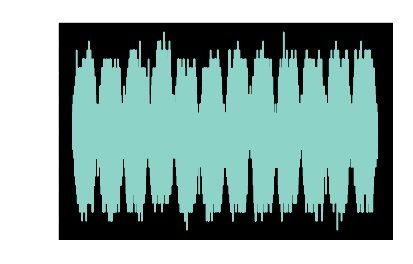

In [105]:
preamble.plot(15)

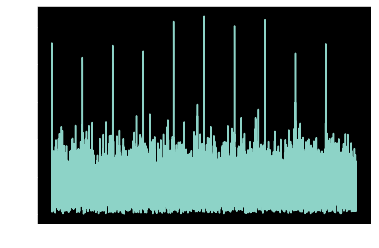

In [107]:
data_slice = preamble.data[15]

corr_vals = sym_utils.shift_and_correlate(
    base_symbol.data, data_slice, samp_per_sym, shifts,
)

plt.plot(corr_vals)

## find peaks 

In [108]:
corrected_width = int(samp_per_sym // shift_step)
corrected_width *= 0.90

peaks = spsig.find_peaks(
    corr_vals, 
    distance=corrected_width,
)[0]

peaks

array([    2,  1602,  3202,  4802,  6402,  8002,  9602, 11202, 12802,
       14393, 15897])

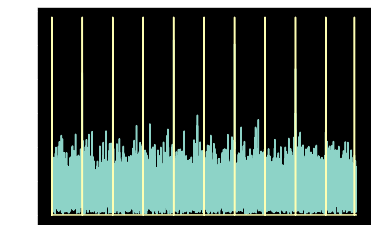

In [110]:
symbol_strips = [
    np.max(corr_vals) * 1.1 if idx in peaks else 0
    for idx, _ in enumerate([0] * len(corr_vals))
]

plt.plot(corr_vals)
plt.plot(symbol_strips)

In [89]:
len(symbol_strips)

15990